In [1]:
import sys
sys.path.insert(1,'../src')
import tensorflow as tf
import nupack as n
#import tf_agents - this import statement is not necessary right now
import tensorflow.keras as keras
from GA_util import create_ppms_fast
import numpy as np
from GA_util import GumbelSoftmax
import matplotlib.pyplot as plt
import util
import GA_util
# print('loaded modules')

Metal device set to: Apple M1 Ultra


2024-08-12 19:53:07.279425: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-08-12 19:53:07.279757: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


2024-08-12 19:53:08.049567: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-08-12 19:53:08.049810: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-12 19:53:08.202598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-12 19:53:08.312893: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-12 19:53:08.444205: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-08-12 19:53:08.997611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


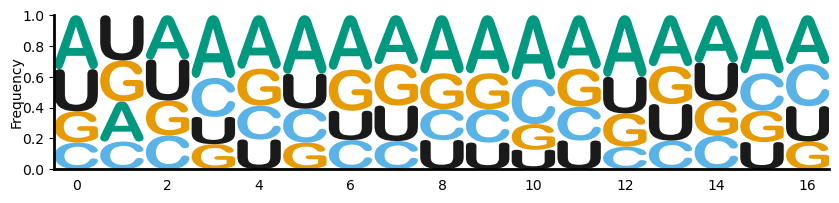

In [2]:
import numpy as np
latent_dim = 8


# loading in the generator and the RBS predictor
generator = tf.keras.models.load_model('gardn_rbs_02_22_24_original_final') 
tmp = generator(np.random.normal(size=(300,8)))
util.plot_logo(tmp[:,:,:,0])


#original 'models/gardn_rbs_02_01_24_V1'

# predictor = tf.keras.models.load_model('../models/predictor_12_3')



In [3]:
generator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 8)]               0         
                                                                 
 reshape_1 (Reshape)         (None, 1, 1, 8)           0         
                                                                 
 spectral_normalization_14 (  (None, 2, 3, 128)        37000     
 SpectralNormalization)                                          
                                                                 
 batch_normalization_3 (Batc  (None, 2, 3, 128)        512       
 hNormalization)                                                 
                                                                 
 re_lu_3 (ReLU)              (None, 2, 3, 128)         0         
                                                                 
 spectral_normalization_15 (  (None, 4, 9, 64)         8211

In [3]:
from GA_util import GumbelSoftmax

random_inputs = np.random.normal(size=(10,8))


generated_seqs = generator(random_inputs)
print(generated_seqs[0,:,:4,0])
print(GA_util.unencode(generated_seqs[0,:,:,0]))



tf.Tensor(
[[0.         1.         0.         0.        ]
 [0.         0.         0.         1.        ]
 [0.         0.         1.         0.        ]
 [0.45344594 0.         0.         0.        ]], shape=(4, 4), dtype=float32)
TACGAGACCGAGCCCAA


In [4]:
# no need to run this cell block for now



#from typing import Any, Dict, Optional, Tuple
#import tf_agents

#import tensorflow as tf
#from tensorflow.keras.layers import Layer

#import logging
#logging.getLogger().setLevel(logging.ERROR)
#EPSILON = 1e-20




#class G(Layer):
    #def __init__(self, axis: Optional[int] = 1, **kwargs) -> None:
        #super(G, self).__init__(**kwargs)

    #def call(self, inputs: tf.Tensor):
        #Inputs will be the output of a generator, shape = BATCH_SIZE, 4, seq_len,1
        #inputs = tf.squeeze(inputs,axis=3)
        #gumbel_dist = tf_agents.distributions.gumbel_softmax.GumbelSoftmax(temperature=1000,logits=tf.transpose(inputs,(0,2,1)))
        #sample = tf.transpose(gumbel_dist.sample(),(0,2,1))
        
        #return tf.nn.softmax(inputs + sample,axis=1)
    
#tmp = generator(np.random.normal(size=(6000,8)))
#util.plot_logo(tmp[:,:,:,0])
#print(GA_util.unencode(tmp[0,:,:]))
#gumbel_tmp = G()(tmp)

#print(GA_util.unencode(gumbel_tmp[0,:,:]))

In [5]:

class ActMaxModel(keras.Model):
    """Combines the generator and predictor into an end-to-end model for training."""

    def __init__(self,generator_model,predictor_model,UTR=True):
        
        super(ActMaxModel, self).__init__()

        self.generator_model = generator_model
        self.predictor_model = predictor_model

    def call(self, inputs):
        seqs = self.generator_model(inputs) # Create a generated sequence
        #softmax_seqs = G()(seqs)
       
        ppms = GA_util.create_ppms_fast(seqs[:,:,:]) # Calculate the PPM # changed from prototype to create ppm 
        defect = self.predictor_model([seqs,ppms])# Return the predicted ON
        return defect
    


# actmax_model = ActMaxModel(generator,predictor,UTR=False)
# tmp = np.random.normal(size=(1,128))
# ON = actmax_model(tmp)
# print('ON:',ON)



In [6]:
def calc_loss(vector, model,output=None):

    # convert to batch format
    vector_batch = tf.expand_dims(vector, axis=0)
    # run the model
    if output == 'on':
        layer_activations = model(vector_batch)[0]
    elif output == 'off':

        layer_activations = model(vector_batch)[1]
        
    elif output =='UTR_high':
        layer_activations = model(vector_batch)[0]
    elif output =='UTR_low':
        layer_activations = model(vector_batch)[0]
    elif output =='MFE':
        layer_activations = model(vector_batch)[0]
    else:
        raise Exception('Accepted output values are "on","off","UTR_high",or "UTR_low"')



    return layer_activations

# val =np.random.normal(size=(128,))
# calc_loss(val,actmax_model,'on')

In [7]:
class ActMax(tf.Module):
    
    def __init__(self,model,output):
        self.model = model
        self.output = output
        print(self.output)

    def __call__(self,vector,steps,step_size):
    
        # print('Improving...')

        loss = tf.constant(0.0)
       
        for n in tf.range(steps):
            
            with tf.GradientTape(watch_accessed_variables=False) as tape:
                
                tape.watch(vector)
                
                loss = calc_loss(vector,self.model,self.output)
                
            
            gradients = tape.gradient(loss,vector)
            

            if self.output == 'on' or self.output == 'UTR_high':

                vector = vector + (gradients*step_size)
            elif self.output == 'off' or self.output == 'UTR_low' or self.output=='MFE':
                
                vector = vector - (gradients*step_size)
            
            
        return loss,vector

In [8]:
def run_act_max(vector,generator_model,predictor_model,steps=100,step_size=0.01,output=None):
    on_save = []
    seq_save = []
    vector = tf.Variable(vector,trainable=True)

    step_size = tf.convert_to_tensor(step_size)
    steps_remaining = steps
    step = 0
    while steps_remaining:
        print(steps_remaining)
        if steps_remaining>100:
            run_steps = tf.constant(100)
        else:
            run_steps = tf.constant(steps_remaining)
        steps_remaining -= run_steps
        step += run_steps
        
        tmp = generator_model(tf.expand_dims(vector, axis=0))
        ppm = GA_util.create_ppms_fast(tmp[:,:,:]) # changing from prototype to create
        print(unencode(tmp[0,:,:,0]))
        if output == 'on':
            val = predictor_model([tmp,ppm])[0].numpy()[0] # Toehold Access notation

        elif output == 'off':
            val = predictor_model([tmp,ppm])[1].numpy()[0]
            
        elif output == 'UTR_high' or output == 'UTR_low':
            val = predictor_model([tmp,ppm])[0].numpy() #UTR access notation
            
        elif output == 'MFE':
            val = predictor_model(tmp[:,:,:,0])[0].numpy()
                    
        
        
        loss,vector = actmax(vector,run_steps,tf.constant(step_size))
        
        
        on_save.append(val)
        seq_save.append(unencode(tmp[0,:,:,0]))



    return vector,seq_save,on_save

In [9]:
#Saving optimization results for experimental testing

import pandas as pd

nseqs = 100
#Save that is latent_dim,number of sequences,and the pre/post latent embeddings
latent_save = np.zeros(shape=(8,nseqs,2))
dat = np.zeros(shape=(nseqs,6))
df = pd.DataFrame(dat,columns=['Pre_Optimized_Sequence','Post_Optimized_Sequence','Pre_Optimized_Value','Post_Optimized_Value','Target_Value','Delta'])


In [10]:
starting_vecs= tf.cast(np.random.normal(size=(100,latent_dim,)),'float32') #Need to change this so we pass the same starting 100 random vectors to each of the predictors for standardization


print(starting_vecs.shape)

(100, 8)


In [11]:
from GA_util import unencode
import time


sizes = [16,32,64,128,256,512]


#for j in range(len(sizes)):
#predictor = tf.keras.models.load_model('../SANDSTORM/tmp_models/sandstorm_size_%i'%sizes[j])
predictor = tf.keras.models.load_model('models/SANDSTORM_rbs')
print(predictor.summary())

actmax_model = ActMaxModel(generator,predictor)
# NSEQS = 100
# OUTPUT = 'ON'
# NSTEPS = 300
# STEP_SIZE = 0.1

# optimization = actmax.run_gan_opt_mult_seqs(actmax_mod,nseqs=NSEQS,output='on',n_steps=NSTEPS,step_size=STEP_SIZE)
# df = optimization[1]

for i in range(nseqs):
    iteration_start = time.time()
    print('start ',i)
    output = 'on'


    step_size = 0.125 #0.1 originally
    steps = 300 #300 originally
    actmax = ActMax(actmax_model,output=output)
    # random_latent_vectors = tf.cast(np.random.normal(size=(latent_dim,)),'float32')
    random_latent_vectors = starting_vecs[i,:] #use the same starting seq set for each individual model
    latent_save[:,i,0] = random_latent_vectors
    seq_vec,seq_save,on_save = run_act_max(vector=random_latent_vectors,generator_model=generator,predictor_model=predictor, steps=steps, step_size=step_size,output=output)
    latent_save[:,i,1] = seq_vec

    df.iloc[i,0] = seq_save[0] #append the pre optimization sequence
    df.iloc[i,1] = seq_save[-1] #append the final optimized sequence
    df.iloc[i,2] = on_save[0]
    df.iloc[i,3] = on_save[-1]
    df.iloc[i,4] = output
    df.iloc[i,5] = on_save[-1] - on_save[0] # Final - Initial
    print(on_save[-1] - on_save[0])
    print('iteration %s took %.2f seconds'%(i,time.time()-iteration_start))

#df.to_csv('../data/sequence_experiments/opt_exp_%s'%sizes[j])
#df.to_csv('data/opt_exp_%s'%sizes[j])

#CHeck this experiment

    

Model: "joint_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 17, 17, 1)]          0         []                            
                                                                                                  
 input_1 (InputLayer)        [(None, 4, 17, 1)]           0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 9, 9, 16)             1040      ['input_2[0][0]']             
                                                                                                  
 conv2d (Conv2D)             (None, 1, 17, 16)            1168      ['input_1[0][0]']             
                                                                                        

/Users/aikaulanova/RnaDesign/GA_util.py:301: RuntimeWarning: divide by zero encountered in divide
  output[where_vals_at] /= distance_vec_at
/Users/aikaulanova/RnaDesign/GA_util.py:304: RuntimeWarning: invalid value encountered in divide
  new_matrix = output / row_sums[:, np.newaxis]


tf.Tensor(400, shape=(), dtype=int32)
ATTACAGAATCAGTAAA
tf.Tensor(300, shape=(), dtype=int32)
ATTACAGAATCAGTAAA
tf.Tensor(200, shape=(), dtype=int32)
ATTACAGAATCCGTAAA
tf.Tensor(100, shape=(), dtype=int32)
ATTACAGAATCCGTAAA
0.03777677
iteration 0 took 8.14 seconds
start  1
on
500
ATCAAGGCTGAGGTAAT
tf.Tensor(400, shape=(), dtype=int32)
ATTAAGGGAGGGGTAAT
tf.Tensor(300, shape=(), dtype=int32)
ATTAAGAGCGAGGTAAT
tf.Tensor(200, shape=(), dtype=int32)
ATTAAGAGCGAGGTAAT
tf.Tensor(100, shape=(), dtype=int32)
ATTAAGAGCGAGGTAAT
0.018258333
iteration 1 took 7.69 seconds
start  2
on
500
TGAGCTATACACGTCAC
tf.Tensor(400, shape=(), dtype=int32)
TGAACTATATACGTCAC
tf.Tensor(300, shape=(), dtype=int32)
TGAACTATATACGTCAC
tf.Tensor(200, shape=(), dtype=int32)
TGAACAATATACGACAC
tf.Tensor(100, shape=(), dtype=int32)
TGAACAATATACGACAC
0.31273222
iteration 2 took 7.69 seconds
start  3
on
500
TCTACTTGCTGAAGATA
tf.Tensor(400, shape=(), dtype=int32)
TCTACTTGCTAAAGATA
tf.Tensor(300, shape=(), dtype=int32)
TCTACTTG

   Pre_Optimized_Sequence Post_Optimized_Sequence  Pre_Optimized_Value  \
0       ATTACAGAATCAGTAAA       ATTACAGAATCCGTAAA             0.052217   
1       ATCAAGGCTGAGGTAAT       ATTAAGAGCGAGGTAAT             0.528141   
2       TGAGCTATACACGTCAC       TGAACAATATACGACAC             0.044074   
3       TCTACTTGCTGAAGATA       TCTACTTGCTAAAGATA            -0.005494   
4       TAGTAAAATGAGATAAC       TAGTAAAATGAGATAAT             0.196780   
..                    ...                     ...                  ...   
95      GTATCATTACGAACGGA       GTATCATTACGAACGGA             0.017162   
96      CTATAGAATTATTCGGA       CTATGCAAGTTATATGG             0.017600   
97      AACAAGAGGCCTTCGTA       AACAAGAGGCCTTCTTA             0.250851   
98      AGCGAGAGATCTTCGCG       AGTGAGGGATCTTCGCT             0.384449   
99      ACCAGCAGGTCTAAGTT       ATGAGGAGGTCAATATT             0.177909   

    Post_Optimized_Value Target_Value     Delta  
0               0.089994           on  0.037777  
1          

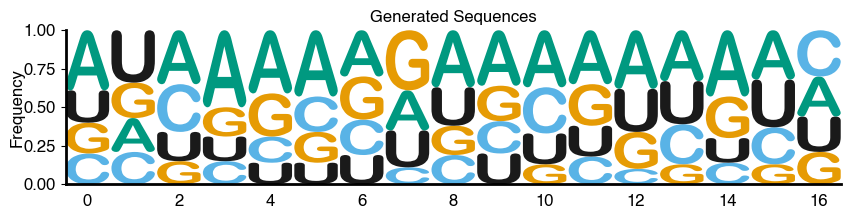

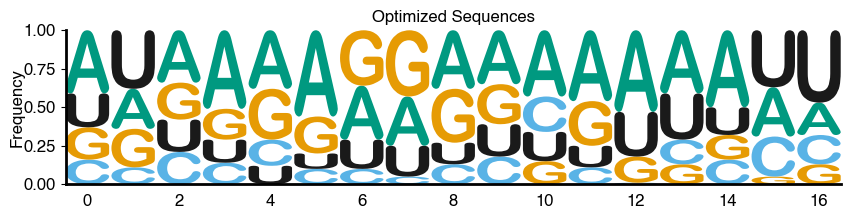

In [24]:
df.head()




pre_seqs = util.one_hot_encode(df[['Pre_Optimized_Sequence']])
optimized_seqs = util.one_hot_encode(df[['Post_Optimized_Sequence']])
print(df)
top_6_rows = df.nlargest(6, 'Delta')
print(top_6_rows)
top_6_rows.to_csv('data/top_6_new.csv', index=False)

util.plot_logo(pre_seqs,title='Generated Sequences')
# plt.savefig('../figures/Toehold GAN Sequence composition.png')
util.plot_logo(optimized_seqs,title='Optimized Sequences')
# plt.savefig('../figures/Optimized Toehold GAN sequence compositions.png')

0.2734684027731419


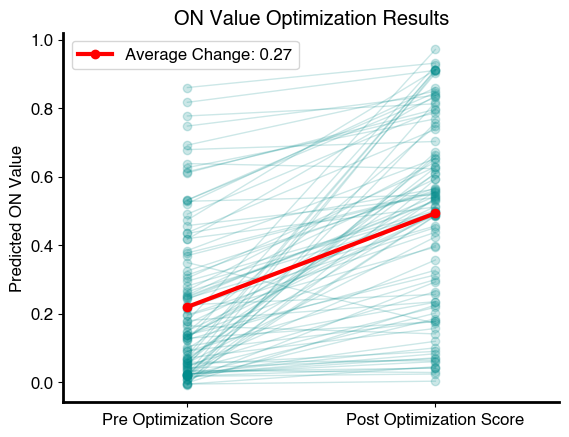

In [25]:
tick_1 = 0.25
tick_2 = 0.75


pre_mean = np.mean(df['Pre_Optimized_Value'])
post_mean = np.mean(df['Post_Optimized_Value'])
print(np.mean(df['Delta']))

plt.figure()
plt.rcParams.update({'font.size': 12,'font.family':'Helvetica'})
plt.xticks(ticks=[tick_1,tick_2], labels=['Pre Optimization Score','Post Optimization Score'])
plt.subplot().spines['right'].set_visible(False)
plt.subplot().spines['top'].set_visible(False)
plt.subplot().spines['left'].set_linewidth(2.0)
plt.subplot().spines['bottom'].set_linewidth(2.0)
plt.ylabel('Predicted ON Value')
plt.xlim([0,1])
plt.title('ON Value Optimization Results')
for i in range(df.shape[0]):
    plt.plot([tick_1,tick_2],[df.iloc[i,2],df.iloc[i,3]],color='darkcyan',alpha=0.2,marker='o',linewidth=1)
    
plt.plot([tick_1,tick_2],[pre_mean,post_mean],color='red',alpha=1,marker='o',linewidth=3,label='Average Change: %.2f'%(post_mean-pre_mean))
plt.legend()
# plt.show()
# plt.savefig('../figures/toehold_on_act_max.png')

In [26]:
print(top_6_rows)

   Pre_Optimized_Sequence Post_Optimized_Sequence  Pre_Optimized_Value  \
54      GTCAGCGTTAAGACGTG       GTTAGGGAGGAGAATTT             0.022990   
17      CTTACACAGATATGTTG       AGGGGAGAAAGATGCCT             0.046494   
76      ATAGAGACGCCATACAA       ATGGAGGAGGCATATAT             0.068013   
59      CTTAGGACCATCTGTTA       ATCAGGAGGATATGTTT             0.078438   
27      ACCAGCCGGTTTCGGTA       ACCAGGAGGTCTTGACT            -0.009554   
37      GTCAAGGATTAGAACGT       GTTAAGGAGGAGAACTT             0.122434   

    Post_Optimized_Value Target_Value     Delta  
54              0.907064           on  0.884074  
17              0.901491           on  0.854997  
76              0.911186           on  0.843173  
59              0.911947           on  0.833509  
27              0.818068           on  0.827622  
37              0.925056           on  0.802622  


In [23]:
df.to_csv('data/optimized_rbs_seqs_V6_220224_final_final.csv')
print('done')  

#v1-3 were the feb 1st ones

done


In [19]:
#from GA_util import unencode
#print(GA_util.unencode(optimized_seqs[0,:,:,0]))

In [ ]:
# ignore this block
sizes = [16,32,64,128,256,512]

#The diagonal will be the predictions for the model that was actually used
delta_save = np.zeros((6,6))
pre_save = np.zeros((6,6))
post_save = np.zeros((6,6))


# plt.figure()
for i in range(len(sizes)):
    tmp = pd.read_csv('../data/sequence_experiments/opt_exp_%i'%sizes[i])
    
    pre_seqs = util.one_hot_encode(tmp[['Pre_Optimized_Sequence']])
    pre_ppms = GA_util.prototype_ppms_fast(pre_seqs)
        
    post_seqs = util.one_hot_encode(tmp[['Post_Optimized_Sequence']])
    post_ppms = GA_util.prototype_ppms_fast(post_seqs)
    
    for j in range(len(sizes)):
        print(sizes[i],sizes[j])
        #First load in the corresponding predictor
        predictor = tf.keras.models.load_model('../SANDSTORM/tmp_models/sandstorm_size_%i'%sizes[j])
        pre_preds = np.mean(predictor([pre_seqs,pre_ppms]))
        post_preds = np.mean(predictor([post_seqs,post_ppms]))
        delta = post_preds - pre_preds
        
        delta_save[i,j] = delta
        pre_save[i,j] = pre_preds
        post_save[i,j] = post_preds
        
        

# unencode the sequences
# use function unencode in ga.util 

In [ ]:
print(delta_save)

In [ ]:
print(pre_save)

In [ ]:
print(post_save)